# T cell epitopes of SARS-CoV2

## Methods

* Predict MHC-I binders for sars-cov2 reference sequences (S and N important)
* Align with sars-cov and get conserved epitopes.
* Find overlap with known epitopes from https://www.viprbrc.org/
* Check MHC restriction of known vs predictions?
* Try 50nm cutoff vs default method
* Best alleles to use?
* Get GIS sequences and translate to proteins
* Multiple sequence alignment of protein to reference
    - find non-conserved binders or clusters

## References

* S. F. Ahmed, A. A. Quadeer, and M. R. McKay, “Preliminary Identification of Potential Vaccine Targets for the COVID-19 Coronavirus (SARS-CoV-2) Based on SARS-CoV Immunological Studies.,” Viruses, vol. 12, no. 3, 2020.
* A. Grifoni et al., “A sequence homology and bioinformatic approach can predict candidate targets for immune responses to SARS-CoV-2,” Cell Host Microbe, pp. 1–10, 2020.
* V. Baruah and S. Bose, “Immunoinformatics-aided identification of T cell and B cell epitopes in the surface glycoprotein of 2019-nCoV,” J. Med. Virol., no. February, pp. 495–500, 2020.

## Epitope Loss in Mutations

* https://www.biorxiv.org/content/10.1101/2020.03.27.012013
* https://www.biorxiv.org/content/10.1101/2020.04.10.029454v1?ct=
* https://www.biorxiv.org/content/10.1101/2020.04.07.030924v1

## Common coronoviruses

* https://www.cdc.gov/coronavirus/types.html


In [1]:
import os, math, time, pickle, subprocess
from importlib import reload
from collections import OrderedDict, defaultdict
import numpy as np
import pandas as pd
pd.set_option('display.width', 150)
import epitopepredict as ep
from epitopepredict import base, sequtils, plotting, peptutils, analysis
from IPython.display import display, HTML, Image
%matplotlib inline
import matplotlib as mpl
import pylab as plt
import pybioviz
from bokeh.io import show, output_notebook
output_notebook()
import pathogenie
from Bio import SeqIO,AlignIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

Loading BokehJS ...

## ref genomes

In [58]:
labels = {'sars':'NC_004718.3','scov2':'NC_045512.2','229E':'NC_002645.1','NL63':'NC_005831.2','OC43':'NC_006213.1','HKU1':'NC_006577.2'}
genomes = []
for l in labels:
    df = ep.genbank_to_dataframe(labels[l]+'.gb',cds=True)
    df['label'] = l
    genomes.append(df)
genomes = pd.concat(genomes)
print (genomes[genomes.label=='scov2'])

   type      protein_id   locus_tag    gene          db_xref                      product                                          note  \
3   CDS  YP_009724389.1  GU280_gp01  ORF1ab  GeneID:43740578           ORF1ab polyprotein  pp1ab; translated by -1 ribosomal frameshift   
19  CDS  YP_009725295.1  GU280_gp01  ORF1ab  GeneID:43740578            ORF1a polyprotein                                          pp1a   
34  CDS  YP_009724390.1  GU280_gp02       S  GeneID:43740568         surface glycoprotein             structural protein; spike protein   
36  CDS  YP_009724391.1  GU280_gp03   ORF3a  GeneID:43740569                ORF3a protein                                           NaN   
38  CDS  YP_009724392.1  GU280_gp04       E  GeneID:43740570             envelope protein           ORF4; structural protein; E protein   
40  CDS  YP_009724393.1  GU280_gp05       M  GeneID:43740571        membrane glycoprotein                      ORF5; structural protein   
42  CDS  YP_009724394.1  GU

In [52]:
def get_seqs(gene):
    sub = genomes[genomes['gene']==gene]
    #print (sub)
    seqs = []
    for i,r in sub.iterrows():
        s=SeqRecord(Seq(r.translation),id=r.label)
        seqs.append(s)
        #print (s)
    return seqs

seqs=get_seqs('S')
aln=pathogenie.clustal_alignment(seqs=seqs)
print (aln)

SingleLetterAlphabet() alignment with 6 rows and 1475 columns
--MFIFLLFLT----------------LTSGSDLDRCTTFDDVQ...HYT sars
--MFVFLVLLP----------------LVSSQCVN--LTTRTQL...HYT scov2
-MFLILLISLPTAFAVIGD-------LKCTSDNINDKDTGPPPI...D-- OC43
--MLLIIFILPTTLAVIGD-------FNCTNFAINDLNTTVPRI...D-- HKU1
--------------------------------------------...HIQ 229E
MKLFLILLVLPLASCFFTCNSNANLSMLQLGVPDNSSTIVTGLL...HVQ NL63


In [53]:
spikesars = SeqIO.to_dict(seqs)['sars'].seq
spikesars

Seq('MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEIFRSDTLYL...HYT')

In [54]:
p = pybioviz.plotters.plot_sequence_alignment(aln, annot = {'polybasic cleavage site':690,'RBD contact residues':480})
#output_file('alignment.html')
show(p)

## mutations within scov2 population

In [6]:
mutations = pd.read_csv('sarscov2_mutations.csv')
mutations[:10]

,mutation,count,protein
0,D614G,792,Spike glycoprotein
1,P214L,769,Replicase polyprotein 1ab
2,Q57H,386,Protein 3a
3,R203K+G204R,288,Nucleoprotein
4,G251V,225,Protein 3a
5,P1327L+Y1364C,222,Replicase polyprotein 1ab
6,T248I,165,Replicase polyprotein 1a
7,L3589F,61,Replicase polyprotein 1a
8,T175M,46,Membrane protein
9,I722V+P748S+L3589F,44,Replicase polyprotein 1a


In [66]:
sc2 = ep.genbank_to_dataframe('NC_045512.2.gb',cds=True)
sc2 = sc2.drop_duplicates('gene')

In [9]:
m1_alleles = ep.get_preset_alleles('broad_coverage_mhc1')
m2_alleles = ep.get_preset_alleles('mhc2_supertypes')

In [11]:
P1 = base.get_predictor('netmhcpan') 
P1.predict_sequences(sc2, alleles=m1_alleles,cpus=10,path='netmhcpan',length=11,overwrite=False,verbose=True)
#P2 = base.get_predictor('mhcflurry') 
#P2.predict_sequences(sc2, alleles=m1_alleles,cpus=10,path='mhcflurry',length=11,overwrite=False)

name                      allele           top peptide        score
predictions done for 11 sequences in 26 alleles
results saved to /home/damien/gitprojects/teaching/sarscov2/netmhcpan


In [13]:
P1.load(path='netmhcpan')
#P2.load(path='mhcflurry')

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [14]:
rb = P1.promiscuous_binders(n=3, cutoff_method='rank', cutoff=10)

In [76]:
reload(analysis)
pb1 = P1.promiscuous_binders(n=3, cutoff=.95)
#pb = P.promiscuous_binders(n=3, cutoff=500, cutoff_method='score')
cl1 = analysis.find_clusters(pb1, genome=sc2)
pb1

,peptide,pos,name,alleles,core,score,mean,median_rank
1872,LAYILFTRFFY,2328,GU280_gp01,15,LAYFTRFFY,1014.1,5899.160000,246.0
3243,STFEEAALCTF,3172,GU280_gp01,13,STEAALCTF,321.8,3944.169231,80.0
4108,YQCAMRPNFTI,3388,GU280_gp01,13,YQMRPNFTI,53.6,3312.146154,153.0
414,DEWSMATYYLF,897,GU280_gp01,13,DSMATYYLF,134.6,5379.046154,157.0
2385,MVMCGGSLYVK,5057,GU280_gp01,13,MVMGGSLYV,25.6,2287.584615,163.0
...,...,...,...,...,...,...,...,...
847,FGADPIHSLRV,1153,GU280_gp01,3,FGAPIHSLR,2655.0,5305.966667,378.0
3005,SAGFSLWVYKQ,6427,GU280_gp01,3,SAFSLWVYK,732.9,2972.466667,383.0
1482,IPGIPKDMTYR,5966,GU280_gp01,3,IPGIPMTYR,2953.6,5633.000000,384.0
2670,PTMCDIRQLLF,4852,GU280_gp01,3,PTDIRQLLF,3753.2,5709.566667,404.0


## find epitopes conserved across an alignment

In [ ]:
#c = analysis.epitope_conservation(seqs, alnrows=aln)
?analysis.epitope_conservation

In [ ]:
seqs = get_seqs('S')
df = pb1[pb1.name=='GU280_gp02']
df.to_csv('N_promiscuous.csv')
peptides = df.peptide

out=[]
for p in peptides:
    c=0
    found=0
    for s in seqs:        
        if p in s.seq:
            found+=1    
    out.append(found)
    
df['conserved'] = out
print (df[df.conserved>=2])
spike_cons = df[df.conserved>=2]
df.conserved.value_counts()

In [ ]:
a = ep.binders_to_coords(pb1)
#b = ep.binders_to_coords(pb2)
f = ep.plot_overview(sc2, coords={'netmhcpan':a},
                         cols=2, figsize=(14,6))


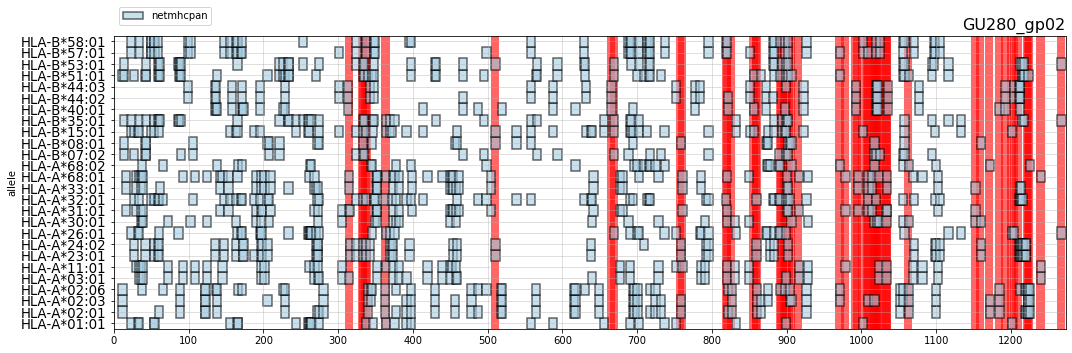

In [68]:
name ='GU280_gp02'
#print (pb[pb.name==name])
ax = ep.plot_tracks([P1],name=name,legend=True,figsize=(15,5),n=3)#,cutoff_method='score')
#r = cl1[cl1.name==name]
#coords = (list(r.start),list(r.end-r.start))
coords = (list(spike_cons.pos),[11 for i in range(len(spike_cons))])
#print (coords)
coords = zip(*coords)
#print (list(coords))
ep.plot_regions(coords, ax, color='red')
plt.savefig('spike_conserved_epitopes.png',dpi=150)

In [ ]:
plot=ep.bokeh_plot_tracks([P1],name=name,n=3,height=200)#,cutoff_method='score')
show(plot)

## exp data from IEDB

In [59]:
exp = pd.read_csv('mhc_ligand_table_export_1591822113.csv')
exp.columns

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (83) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Index(['MHC ligand ID', 'Reference ID', 'Type', 'PubMed ID', 'Authors', 'Journal', 'Date', 'Title', 'Submission ID', 'Epitope ID', 'Object Type',
       'Sequence', 'Starting Position', 'Ending Position', 'Non-peptidic epitope ChEBI ID', 'Antigen Name', 'Parent Protein',
       'Parent Protein Accession', 'Organism Name', 'Parent Species', 'Parent Species Accession', 'Epitope Comments', 'Epitope Relationship',
       'Object Type.1', 'Description', 'Starting Position.1', 'Ending Position.1', 'Non-peptidic object Accession', 'Synonyms', 'Antigen Name.1',
       'Parent Protein.1', 'Organism Name.1', 'Parent Organism', 'Name', 'Host ID', 'Geolocation', 'MHC Types Present', 'Process Type',
       'Disease State', 'Disease Stage', 'Processed Antigen Epitope Relation', 'Processed Antigen Object Type', 'Processed Antigen Description',
       'Processed Antigen Starting Position', 'Processed Antigen Ending Position', 'Non-peptidic Processed Antigen ChEBI ID',
       'Processed Antigen Source 

In [86]:
cols = ['Sequence','Starting Position','Ending Position','Parent Protein','Antigen Name','Allele Name']
subset = exp[exp['Parent Protein']=='Spike glycoprotein']
subset[cols]
exp_peptides = subset.groupby('Sequence').agg({'Response Frequency':np.sum})

In [91]:
exp_peptides

,Response Frequency
Sequence,
AAAYFVGYLK,0.0
AAYFVGYLK,0.0
ADAGFMKQY,0.0
ADYSVLYNST,0.0
AEIRASANLA,0.0
...,...
YFPREGVFVF,0.0
YISDAFSLDV,0.0
YRYLRHGKL,0.0


## view residues on structure

In [ ]:
ranges = list(zip(r.start,r.end))
ranges = [list(range(r[0],r[1])) for r in ranges]

In [25]:
from pymol import cmd

In [26]:
def highlight_residues(residues, chain):
   
    from pymol import stored
    vals = {}   
    for r in residues:
        sel = '(chain %s and resi %s)' %(chain,r)
        cmd.color('red', sel)
    return
    
def find_interacting_residues():
    """Find set of residues"""
   
    from pymol import stored
    vals = {}
    residues = range(1,50)
    offset=3
    for p in residues:
        sel1 = '(c. A and (donor or acceptor) and resi %s)' %p
        cmd.select('near','c. B within 4 of %s' %sel1)
        #cmd.show('stick','near')
        #cmd.color('green', 'near')
        stored.lst=[]
        cmd.iterate('near',"stored.lst.append((chain,resi,resn,name))")
        #print (stored.lst)       
        for r in stored.lst:         
            cmd.show('stick','resi %s' %r[1])
            cmd.color('red','resi %s' %r[1])
    return


In [ ]:
def draw_spike():
    cmd.reinitialize()
    #cmd.load('6lzg.pdb')
    cmd.load('model_spike.pdb')
    cmd.orient()
    cmd.remove('resn hoh')
    cmd.hide('all')
    cmd.show('cartoon','chain C')
    cmd.turn('x', -90)
    cmd.turn('z', 200)
    cmd.bg_color('white')
    cmd.color('marine','chain C')
    cmd.color('gray','chain D')
    #cmd.select('rbd', '(chain C and resi 455+486+493+494+501+505)')
    cmd.zoom('chain C')
    #cmd.show('sticks', 'rbd')
    #cmd.label('rbd and n. c' , 'resn+resi')
    cmd.set('label_position', (1,2,3))
    return

def highlight_ranges():
    for x in ranges:
        highlight_residues(x,'C')
        
def save_image(filename):
    cmd.set('ray_trace_mode',1)
    cmd.set('ray_trace_gain',0)
    cmd.png(filename, width=1200,dpi=150)
    #cmd.save('model_spike.pse')
    Image(filename='model_spike.png')
    
draw_spike()
#highlight_ranges()
save_image('model_spike.png')
Image(filename='model_spike.png')